# RNArtist

Interesting project, see these [github](https://github.com/fjossinet/RNArtist), [twitter](https://twitter.com/rnartist_app) accounts.

Similar to fornac or varna, using it means instrumenting the core engine of something driving a more elaborate GUI project.

To plot something, you create a script in the DSL the project invented for the purpose.

The documentation of that DSL is mostly a single page of human-generated example files/scripts--some with syntax that seems to be out of sync with the current parser. Alpha.

Below I use the published docker image the developer made, and construct a plot script (using matplotlib to generate color values).

In [1]:
import matplotlib.pyplot as plt
import matplotlib; print(f'Matplotlib: {matplotlib.__version__}')
from IPython.core.display import SVG
import IPython; print(f'IPython: {IPython.__version__}')

Matplotlib: 3.6.0
IPython: 7.27.0


## Using docker

In [2]:
!docker --version
!docker pull fjossinet/rnartistcore
!docker image ls | grep rna

Docker version 23.0.4, build f480fb1e37
Using default tag: latest
latest: Pulling from fjossinet/rnartistcore
Digest: sha256:53992f1898a37b9682d7011db060db96e81e6e725d6e295cdfad5ef9c6c975aa
Status: Image is up to date for fjossinet/rnartistcore:latest
docker.io/fjossinet/rnartistcore:latest
fjossinet/rnartistcore                                                          latest                   d2aeca7b1ee0   18 months ago   2.12GB


Sheesh. Out of curiosity, here's what's in that:

In [3]:
import json
import humanize
import pprint

hist = !docker history --format json --no-trunc --human=false fjossinet/rnartistcore 
hist = sorted([json.loads(l) for l in hist],
              key=lambda x: int(x['Size']), reverse=True)
hist = [{'layer': c['CreatedBy'], #''.join(c['CreatedBy']),
         'size': humanize.naturalsize(c['Size'])} for c in hist]

print('-'*80)
for layer in hist:
    print(f'Size: {layer["size"]}')
    print(layer["layer"])
    print('-'*80)

--------------------------------------------------------------------------------
Size: 644.2 MB
RUN /bin/sh -c apt-get update && apt-get install -y git wget build-essential default-jdk maven # buildkit
--------------------------------------------------------------------------------
Size: 528.3 MB
/bin/sh -c set -ex;  apt-get update;  apt-get install -y --no-install-recommends   autoconf   automake   bzip2   dpkg-dev   file   g++   gcc   imagemagick   libbz2-dev   libc6-dev   libcurl4-openssl-dev   libdb-dev   libevent-dev   libffi-dev   libgdbm-dev   libglib2.0-dev   libgmp-dev   libjpeg-dev   libkrb5-dev   liblzma-dev   libmagickcore-dev   libmagickwand-dev   libmaxminddb-dev   libncurses5-dev   libncursesw5-dev   libpng-dev   libpq-dev   libreadline-dev   libsqlite3-dev   libssl-dev   libtool   libwebp-dev   libxml2-dev   libxslt-dev   libyaml-dev   make   patch   unzip   xz-utils   zlib1g-dev     $(    if apt-cache show 'default-libmysqlclient-dev' 2>/dev/null | grep -q '^Version:';

# Rendering

In [4]:
# They made this bash script to instrument calling the docker image:
#!wget https://raw.githubusercontent.com/fjossinet/RNArtistCore/557f40feb8abfaddb99d5bf715d178df77957ab6/scripts/plot_2ds.sh
#!chmod +x ./plot_2ds.sh

plot_rnartist = './plot_2ds.sh'

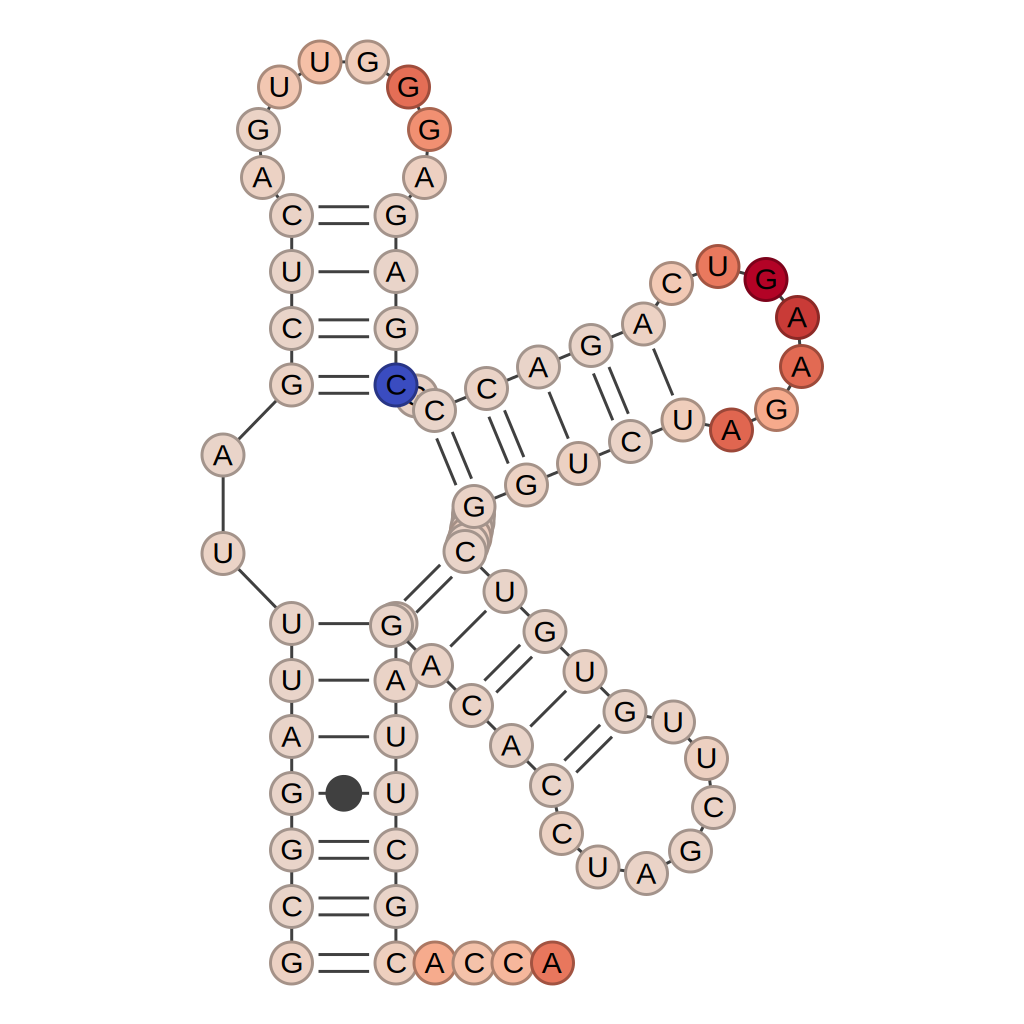

In [5]:
def scale_colors(colors_dict, as_hex=True, cmap=None, reverse=False):
    '''
    A dictionary with values containing scalars which need to 
    be scaled according to some color map. The keys are irrelevant.
    The color map will be normalized to the range of values within 
    color_dict.
    :param colors_dict: Dictionary of k=nucleotide_index, v=color as float.
    :param as_hex: Boolean, if True then returns '#RRGGBB' hex string rather than (r,g,b)
    :param cmap: A color map to be used to scale the colors.
    :param reverse: Reverse the color map
    :return: Another dictionary containing rgb triples as values.
    '''
    # This code adapted from: https://github.com/ViennaRNA/forgi/blob/0fca4a85bbe74f3e12cf1505e37a713c4454d34c/forgi/visual/fornac.py
    
    if cmap is None:
        import matplotlib.pyplot as plt
        cmap = plt.get_cmap('Blues')

    values = colors_dict.values()
    min_value = min(values)
    max_value = max(values)

    new_dict = {}
    for key in colors_dict:
        if reverse:
            color = cmap(
                1 - ((colors_dict[key] - min_value) / (max_value - min_value)))
        else:
            color = cmap(
                (colors_dict[key] - min_value) / (max_value - min_value))
        r,g,b = int(255 * color[0]), int(255 * color[1]), int(255 * color[2])
        
        new_dict[key] = (r,g,b) if not as_hex else "#{r:02x}{g:02x}{b:02x}".format(r=r, g=g, b=b)

    return new_dict

def rnaartist_color_str(nucleotide_colors):
    template = '''
    color {{
        location = "{ind}:1"
        value = "{hexcolor}"
    }}
    '''
    
    s = ''
    for bi, c_rgb in nucleotide_colors.items():
        s += template.format(ind=bi+1, hexcolor=c_rgb)
    return s

# note: /project is the path prefix mounted to ./ in container-world
seq    = 'GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGGUCCUGUGUUCGAUCCACAGAAUUCGCACCA'
struct = '(((((((..((((........)))).(((((.......))))).....(((((.......))))))))))))....'
shape_data = [0.049, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.02, 0.0, 0.0, 0.01, 0.039, 0.02, 0.205, 0.302, 0.127,
              1.052, 0.779, 0.068, 0.01, 0.0, 0.0, -2, 0.01, 0.0, 0.01, 0.0, 0.0, 0.039, 0.175, 0.964, 1.607, 1.383, 
              1.081, 0.546, 1.11, 0.107, 0.01, 0.049, 0.029, 0.01, 0.01, 0.0, 0.01, 0.078, 0.01, 0.0, 0.0, 0.0, 0.02, 
              0.0, 0.01, 0.058, 0.01, 0.01, 0.01, 0.02, 0.029, 0.0, 0.0, 0.01, 0.01, 0.0, 0.01, 0.01, 0.0, 0.0, 0.0, 
              0.0, 0.088, 0.536, 0.273, 0.409, 0.984]
nucleotide_colors = scale_colors(dict((i, v) for i,v in enumerate(shape_data)),
                                 cmap=plt.get_cmap('coolwarm'))
color_in_dsl = rnaartist_color_str(nucleotide_colors)

write_to = 'test.svg'
s = f'''rnartist {{
  file = "/project/{write_to}"
  ss {{
    rna {{
      sequence = "{seq}"
    }}
    bracket_notation = "{struct}"
  }}
  theme {{
    details_lvl = 5
    
    {color_in_dsl}
    
    color {{
        type = "n"
        value = "black"
    }}
  }}
  layout {{
    junction {{
        type = 3
        out_ids ="w e"
    }}
  }}
}}
'''
plot_instruction_file = './test.kts'
with open(plot_instruction_file, 'w') as f:
    f.write(s)
!{plot_rnartist} {plot_instruction_file}

# the output file name is like: filename defined in the script + molecular chain name (default name is 'A'). 
actually_wrote_to = write_to[:-len('.svg')] + '_A.svg'
SVG(filename=actually_wrote_to)